In [1]:
import gc
import numpy as np
import pandas as pd
import keras.backend as K
from rnn_mimic_LSTMUnit import return_loaded_model
from seaborn import heatmap
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import kurtosis

# plot part.
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import os

In [2]:
def load_data(root_path, feature="MI"):
    X_TRAIN = pickle.load(open(os.path.join(root_path, f'X_TRAIN_{feature}.txt'), 'rb'))
    Y_TRAIN = pickle.load(open(os.path.join(root_path,f'Y_TRAIN_{feature}.txt'), 'rb'))
    Y_VAL = pickle.load(open(os.path.join(root_path, f'Y_VAL_{feature}.txt'), 'rb'))
    X_VAL = pickle.load(open(os.path.join(root_path, f'X_VAL_{feature}.txt'), 'rb'))
    Y_TEST = pickle.load(open(os.path.join(root_path, f'Y_TEST_{feature}.txt'), 'rb'))
    X_TEST = pickle.load(open(os.path.join(root_path, f'X_TEST_{feature}.txt'), 'rb'))
    y_boolmat_test = pickle.load(open(os.path.join(root_path, f'y_boolmat_test_{feature}.txt'), 'rb'))
    x_boolmat_test = pickle.load(open(os.path.join(root_path, f'x_boolmat_test_{feature}.txt'), 'rb'))
    no_features_cols = pickle.load(open(os.path.join(root_path,f'no_feature_cols_{feature}.txt'), 'rb'))
    features = pickle.load(open(os.path.join(root_path,f'features_{feature}.txt'), 'rb'))

    
    # X = np.concat([X_TRAIN, X_TEST], axis=0)
    # Y = np.concatenate([Y_TRAIN, Y_VAL], axis=0)
    return X_TRAIN, Y_TRAIN, Y_VAL, X_VAL, Y_TEST, X_TEST, y_boolmat_test, x_boolmat_test, no_features_cols, features

342/342 [==============================] - 4s 7ms/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


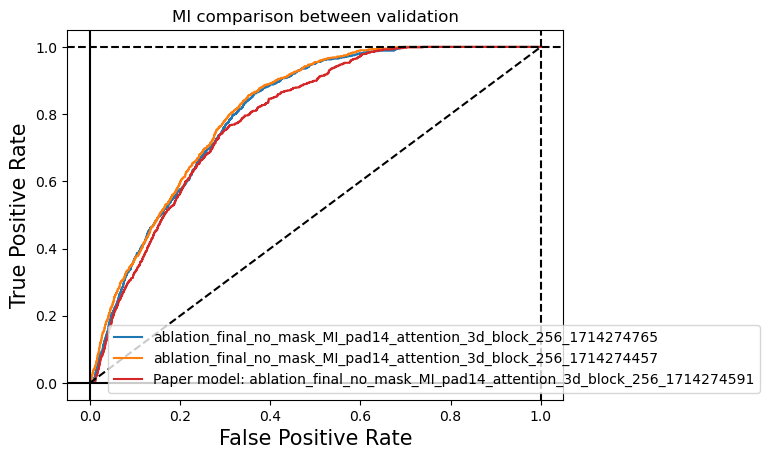

In [3]:
##############
## FIGUREs  ##
##############
def create_color_list(length):
    template = sns.color_palette()
    if length == 1:
        return [template[3]] # red
    

def plotAllVariation(target, variation, savePlot=True):
    model_names_list_template = {
        # "attention":[
        #     "ablation_final_no_mask_{0}_pad14_attention_3d_block_time_features_256",
        #     "ablation_final_no_mask_{0}_pad14_attention_none_256",
        #     "ablation_final_no_mask_{0}_pad14_attention_3d_block_256",
        # ],
        "LSTMUnit":[
            "ablation_final_no_mask_{0}_pad14_attention_3d_block_64",
            "ablation_final_no_mask_{0}_pad14_attention_3d_block_128",
            "ablation_final_no_mask_{0}_pad14_attention_3d_block_512",
            "ablation_final_no_mask_{0}_pad14_attention_3d_block_1024",
            "ablation_final_no_mask_{0}_pad14_attention_3d_block_256",
        ]
        # "validation":[
        #     "ablation_final_no_mask_MI_pad14_attention_3d_block_256_1714274765",
        #     "ablation_final_no_mask_MI_pad14_attention_3d_block_256_1714274457",
        #     "ablation_final_no_mask_MI_pad14_attention_3d_block_256_1714274591"
        # ]
    }
    


    list_of_model_names = [item.format(target) for item in model_names_list_template[variation]]

    current_palette = sns.color_palette() 
    if len(list_of_model_names) == 5:
        color_list = current_palette[0:3] + [current_palette[4], current_palette[3]]
    elif len(list_of_model_names) == 3:
        color_list = current_palette[0:2] + [current_palette[3]]
    elif len(list_of_model_names) == 2:
        color_list = current_palette[0:2]
    fpr_tprs = []
    roc_auc_scores_ = {"model":[], "roc_auc_score":[]}
    for model_name in list_of_model_names:
        m = return_loaded_model(model_name=model_name)
        # We assume no mask here
        X_TEST_COPY = np.copy(X_TEST)
        X_TEST_COPY[x_boolmat_test] = 0
        Y_PRED_TEST = m.predict(X_TEST_COPY)

        
        (fpr_mask_0, tpr_mask_0, thresholds_mask_0) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_TEST[~y_boolmat_test])
        fpr_tprs.append((fpr_mask_0, tpr_mask_0))
        roc_auc_score_ = roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_TEST[~y_boolmat_test])
        roc_auc_scores_["model"].append(model_name)
        roc_auc_scores_["roc_auc_score"].append(roc_auc_score_)

    fig, ax = plt.subplots()
    ax.set_facecolor('white')
    counter = 1
    for color, fpr_tpr_tuple, model_name in zip(color_list, fpr_tprs, list_of_model_names):
        if counter != len(color_list):
            plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label=model_name, color=color)
            counter += 1
        else:
            plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label=f"Paper model: {model_name}", color=color)

    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.axhline(0, color='black')
    plt.axhline(1.0, color='black', linestyle='--')
    plt.axvline(0, color='black')
    plt.axvline(1.0, color='black', linestyle='--')
    plt.title(f"{target} comparison between {variation}")
    legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.41, 0))
    df = pd.DataFrame.from_dict(roc_auc_scores_)
    # df["target"] = target
    # df["variation"] = variation
    if savePlot:
        plt.savefig('./figures/{0}_{1}_ablation.eps'.format(target, variation), format='eps',
                    dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')
    return df



variations = ["LSTMUnit"]
targets = ["MI", "SEPSIS", "VANCOMYCIN"]
# variations = ["validation"]
# targets = ["MI"]


stats = []
for variation in variations:
    for target in targets:
        root_path = "./pickled_objects/"
        X_TRAIN, Y_TRAIN, Y_VAL, X_VAL, Y_TEST, X_TEST, y_boolmat_test, x_boolmat_test, no_features_cols, features = load_data(root_path, feature=target)
        roc_df = plotAllVariation(target="MI", variation=variation, savePlot=True)
        stats.append(roc_df)




In [4]:
df = pd.concat(stats, axis=0, ignore_index=True)
df.to_csv("./stats_check.csv", index=False)